# Unsupervised Learning – K-Means and DBSCAN

## 1. Data import

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]

# We take only 10000 elements from 70000 available in order not to fry my computer
X = X[:10000]
y = y[:10000]

**We import the function that will visualise the clustering done by K-means models**

### Clustering with K-Means

We apply the K-Means algorithm for different values of `k` (number of clusters).  
The goal is to determine how many digit-like groups the algorithm can discover.

For each value of `k` (from 8 to 12), we:
- Train K-Means with multiple initializations
- Evaluate using the **silhouette score**, which measures clustering quality
- Visualize the clusters in 2D using PCA

This allows us to test whether the optimal number of clusters corresponds to the 10 actual digits.

In [2]:
from sklearn.decomposition import PCA                      # THIS FUNCTION IS IMPORTED FROM THE STACK-OVERFLOW WEBSITE
from matplotlib.colors import ListedColormap               # IT HELPS VISUALISE THE DEVISIONS MADE BY THE MODEL
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundaries(model, X):
    # readuce to 2D
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # create mesh
    h = 3.0
    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # predict the clusters on the mesh
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # borders + points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(plt.cm.tab10.colors))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=model.labels_, s=10, cmap=ListedColormap(plt.cm.tab10.colors))
    plt.title(f"KMeans clustering (k={model.n_clusters})")

## Kmeans clustering (there are 10 digits, so k = 10 clutering should be the best)

###  Silhouette Score Evaluation

We compute the silhouette score for each K-Means model.  
The silhouette score indicates how well-separated and cohesive the clusters are.

The silhouette score ranges from -1 to 1, where higher values indicate better-defined clusters.

We save the list of scores to a Pickle file `kmeans_sil.pkl` for further analysis.

k=8, silhouette score = 0.0582
kmeans8.png
k=9, silhouette score = 0.0624
kmeans9.png
k=10, silhouette score = 0.0621
kmeans10.png
k=11, silhouette score = 0.0630
kmeans11.png
k=12, silhouette score = 0.0631
kmeans12.png


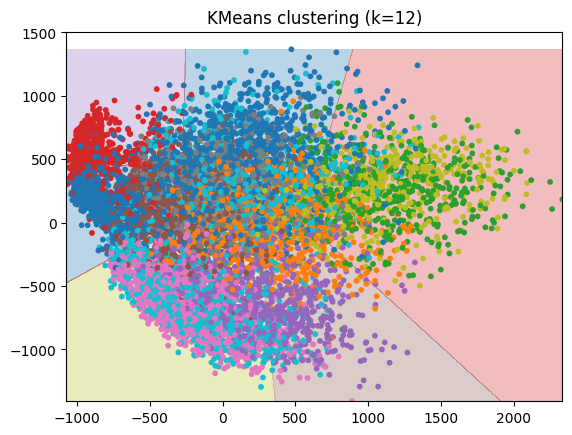

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pickle

# list for scores of the models for each k value
silhouette_scores = []

for iter in range(8,13):
    k = iter
    kmeans = KMeans(n_clusters = k, n_init = 10)
    y_pred = kmeans.fit_predict(X) 

    score = silhouette_score(X, y_pred)
    silhouette_scores.append(score)
    print(f"k={k}, silhouette score = {score:.4f}")

    plt.cla()
    plot_decision_boundaries(kmeans, X)
    f = f'kmeans{iter}.png'
    plt.savefig(f)
    print(f)

**We save the results to pickle file**

In [4]:
import pickle

with open("kmeans_sil.pkl", "wb") as f:
    pickle.dump(silhouette_scores, f)

### Matching K-Means Clusters to Digits

To analyze how K-Means groups align with actual digits, we:
- Set `k=10` (since there are 10 digits)
- Compute the **confusion matrix** between true labels (`y`) and cluster assignments
- For each digit (row in the matrix), we find the most frequent cluster assigned to it

We save the list of best-matching cluster indices to `kmeans_argmax.pkl`.

In [5]:
from sklearn.metrics import confusion_matrix

# KMeans for 10 clusters seem to be the best
kmeans = KMeans(n_clusters=10, n_init=10)
y_pred = kmeans.fit_predict(X)

# confusion matrix
cm = confusion_matrix(y, y_pred)

# we display the confusion matrix
print("Confusion matrix:")
print(cm)

Confusion matrix:
[[ 97   4   2   0 787  19  45   7  39   1]
 [  2 549   1 570   0   1   1   2   0   1]
 [ 24 126   4  55   7  22  61 662  23   7]
 [239  93  22   6   6  12 602  31   9  12]
 [  1  43 254  24   0 377   0   4  14 263]
 [250 239  54   5   9  28 233   2  22  21]
 [ 13 116   0   4  14  96   5   9 757   0]
 [  1  49 435  37   1 105   1   4   0 437]
 [506  88  24  29   4  33 206   8  18  28]
 [  2  28 388   5   5 240  17   0   3 290]]


In [6]:
# indexes of biggest values in each row
argmax_indices = [np.argmax(row) for row in cm]

# We delete the duplicate values and sort te list
unique_sorted = sorted(set(argmax_indices))

# saving reuslts to pickle
with open("kmeans_argmax.pkl", "wb") as f:
    pickle.dump(unique_sorted, f)

# displey the saved list
print("Saved list:", unique_sorted)

Saved list: [0, 2, 3, 4, 5, 6, 7, 8, 9]


## DBSCAN clustering (there are 10 digits, so k = 10 clutering should be the best)

###  Estimating Epsilon for DBSCAN

DBSCAN requires setting the `eps` parameter — the maximum distance for neighborhood points.  
We estimate it by calculating all pairwise distances between the first 300 samples and the full dataset.

We extract the **10 smallest non-zero distances** and save them to `dist.pkl`.  
These values help us choose a meaningful `eps` value for clustering.

In [7]:
import numpy as np
import pickle

# choose only first 300 elements
X_subset = X[:300]

# calculate euclidean lengths
distances = []
for x1 in X_subset:
    dists = np.linalg.norm(X - x1, axis=1)
    distances.extend(dists[dists > 0])  # we skip the lengths equal 0

# find 10 smallest lengths
distances = np.array(distances)
smallest_10 = np.sort(distances)[:10]

# Zapisz do Pickle
with open("dist.pkl", "wb") as f:
    pickle.dump(list(smallest_10), f)

print("dist.pkl zapisany:", smallest_10)

dist.pkl zapisany: [374.91599059 387.95876069 398.37419595 405.27644886 406.13544539
 413.44528054 413.951688   419.58312645 419.58312645 425.05646684]


In [8]:

# avarage (mean) of the 3 smallest distances
s = np.mean(smallest_10[:3])

# generate eps values: from s to s + 10% * s, co 4% * s
eps_values = np.arange(s, s + 0.10 * s + 0.0001, 0.04 * s)
print("eps_values:", eps_values)

eps_values: [387.08298241 402.56630171 418.04962101]


###  Clustering with DBSCAN

Using the average of the 3 smallest distances, we create a range of `eps` values.

For each `eps`:
- Run DBSCAN on the entire dataset
- Count how many unique clusters (excluding noise) were found
- Save the number of clusters to `dbscan_len.pkl`

This experiment shows how DBSCAN behaves under different sensitivity levels.


In [9]:
from sklearn.cluster import DBSCAN

labels_counts = []

for epsval in eps_values:
    dbscan = DBSCAN(eps = epsval, min_samples = 5)
    labels = dbscan.fit_predict(X)
    unique_labels = set(labels)
    labels_counts.append(len(unique_labels))

# saving to pickle
with open("dbscan_len.pkl", "wb") as f:
    pickle.dump(labels_counts, f)

print("dbscan_len.pkl saved:", labels_counts)

dbscan_len.pkl saved: [3, 4, 7]


##  Summary and Observations

We tested two unsupervised clustering algorithms on handwritten digits.

- **K-Means** performed well when the number of clusters was set to 10, close to the expected digit count.
- **DBSCAN** required tuning `eps`, but provided insight into the density of data.

Silhouette scores and visual inspection were key to understanding clustering performance.

The notebook provides a framework for evaluating unsupervised models without ground-truth labels.
